# Introduction

This notebook presents the analysis and implementation of a classification model. The primary goal of this project is to build a predictive model capable of distinguishing between two classes—Class 0 (non-target) and Class 1 (target)—in a dataset characterized by significant class imbalance.

**Objective:**

Develop and evaluate a machine learning model to predict the target class with a strong emphasis on minimizing false negatives while maintaining reasonable overall model performance.


**Key Steps:**

1. Data Preprocessing and EDA:
Process of examining and summarizing a dataset to uncover patterns, identify anomalies, test hypotheses, and check assumptions before applying machine learning models.

2. Model Development:
Evaluate multiple algorithms to identify the best-performing model, considering metrics tailored for imbalanced datasets.

3. Evaluation Metrics:
Assess model performance using metrics such as precision, recall, F1-score, ROC AUC, and PR AUC to ensure the model meets project objectives.

4. Test Case Analysis:
Validate the model’s performance on samples that represents an out-of-distribution (OOD).


  
    
      
      


**Data Scientist:** Arthur Yuan


# Setup

In [ ]:
%pip install -q -U ppscore
%pip install -q -U pandas

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages tha

In [ ]:
# General
from tqdm import tqdm
import time

# Data manipulation and analysis
import pandas as pd
import ppscore as pps
import numpy as np

# Visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Stats and model development
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    brier_score_loss,
    precision_recall_curve,
    auc,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.metrics import ConfusionMatrixDisplay
import shap

In [ ]:
# Loading dataset
df = pd.read_csv('/content/dataset_test_ds_v2-Atualizado.csv', encoding='latin1')

# EDA

This code provides an overview of the dataset, showing the number of entries, the count of non-null values for each column, and their respective data types. It helps identify missing values (e.g., V1, V2, V5) and ensures that key columns like TARGET and SAFRA are fully populated, aiding in early data quality checks and preparation.

In [ ]:
# Checking the basic info
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SAFRA   11169 non-null  int64  
 1   V1      10437 non-null  float64
 2   V2      10942 non-null  float64
 3   V3      11169 non-null  float64
 4   V4      11169 non-null  int64  
 5   V5      10263 non-null  float64
 6   V6      11169 non-null  int64  
 7   V7      11008 non-null  float64
 8   V8      10821 non-null  float64
 9   V9      11057 non-null  float64
 10  V10     11169 non-null  int64  
 11  V11     11169 non-null  object 
 12  V12     11169 non-null  object 
 13  CEP     11169 non-null  int64  
 14  TARGET  11169 non-null  int64  
dtypes: float64(7), int64(6), object(2)
memory usage: 1.3+ MB


In [ ]:
# Fixing SAFRA and CEP types
df[['SAFRA','CEP']] = df[['SAFRA','CEP']].astype('object')

In [ ]:
# Sample of the dataset
df.head()

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,CEP,TARGET
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,0,SP,São Paulo,8412006,0
1,201910,0.0,4.4,35.00,1369,0.0,0,63.98,1.0,0.0,0,RJ,Rio de Janeiro,23580304,0
2,201906,0.0,0.7,52.99,1228,0.0,0,98.84,0.0,0.0,0,MG,Belo Horizonte,30421310,0
3,201910,0.0,63.3,810.00,0,0.0,1,9237.21,0.0,0.0,0,SP,São Paulo,8253410,0
4,201902,0.0,4.1,17.50,0,0.0,1,27.70,1.0,0.0,0,ES,Vitória,29017186,0


In [ ]:
# Checking basic statistics
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,TARGET
count,10437.000000,10942.000000,11169.000000,11169.000000,10263.000000,11169.000000,11008.000000,10821.000000,11057.000000,11169.000000,11169.000000
mean,0.106448,19.750658,531.046901,1396.048438,0.186982,0.177903,4345.434375,0.397468,0.008592,0.030531,0.010744
std,0.308425,25.442371,906.626021,1736.590512,0.640979,0.382448,11527.310213,0.489397,0.092297,0.172051,0.103100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.800000,37.520000,30.000000,0.000000,0.000000,77.865000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,135.000000,1321.000000,0.000000,0.000000,415.185000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,25.300000,520.000000,1988.000000,0.000000,0.000000,2804.085000,1.000000,0.000000,0.000000,0.000000
max,1.000000,100.000000,8540.000000,15616.000000,11.000000,1.000000,143268.550000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Samples by state
df['V11'].value_counts()

,count
V11,
SP,4876
MG,2283
RJ,2209
ES,1801


In [ ]:
# Samples by city
df['V12'].value_counts()

,count
V12,
São Paulo,3463
Rio de Janeiro,1231
Belo Horizonte,1129
Vitória,504
Serra,504
Guarulhos,450
Campinas,387
Contagem,347
Nova Iguaçu,308


In [ ]:
df['CEP'].value_counts()

,count
CEP,
8420400,713
8253410,703
8411200,703
8040220,694
8412006,650
...,...
29200380,33
26110675,33
26110690,31


In [ ]:
# differentiating the features into lists to be used in further analysis
numerical_features = ['V1','V2', 'V3', 'V4', 'V6', 'V5','V7', 'V8', 'V9', 'V10']
boolean_features =  ['V1','V6','V8','V9','V10']
continuous_features = ['V2', 'V3', 'V4', 'V5','V7']

## Target

This code calculates the proportion of each class in the TARGET column, revealing a highly imbalanced dataset with a negative rate of 98.93% and a positive rate of only 1.07%. Such imbalance highlights the need for specialized techniques, like resampling or adjusted metrics, to effectively model and evaluate the data.

In [ ]:
# Analyzing the target
df['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0,0.989256
1,0.010744


The following code examines the proportion of the TARGET classes across different time periods (SAFRA). The results indicate fluctuations in the positive rate over time, ranging from 0.75% to 1.62%. Such temporal analysis is crucial for understanding potential shifts in data distribution, which could impact model performance and require time-aware strategies during modeling.

In [ ]:
# Analyzing target over time
df_proportion = df.groupby('SAFRA')['TARGET'].value_counts(normalize=True).reset_index()
df_proportion['proportion'] = df_proportion['proportion'].apply(lambda x: x*100)
df_proportion

,SAFRA,TARGET,proportion
0,201901,0,98.857736
1,201901,1,1.142264
2,201902,0,98.555957
3,201902,1,1.444043
4,201903,0,99.159664
5,201903,1,0.840336
6,201904,0,99.042553
7,201904,1,0.957447
8,201905,0,98.752599
9,201905,1,1.247401


In [ ]:
df_proportion['SAFRA'] = df_proportion['SAFRA'].astype('object')

The plot below visualizes the positive rate over time along with the overall mean for the period.

In [ ]:
fig = go.Figure()

#for target in df_proportion['TARGET'].unique():
filtered_df = df_proportion[df_proportion['TARGET'] == 1]
fig.add_trace(go.Scatter(
    x=filtered_df['SAFRA'],
    y=filtered_df['proportion'],
    mode='lines+markers',
    name=f"Target"
))

mean_1 = filtered_df[filtered_df['TARGET'] == 1]['proportion'].mean()


# Add a horizontal mean line
fig.add_hline(
    y=mean_1,
    line_dash="dash",
    line_color="black",
    annotation_text=f"Mean: {mean_1:.2f}",
    annotation_position="bottom right"
)

fig.update_layout(
    title="Positive rate by SAFRA",
    xaxis_title="SAFRA",
    yaxis_title="Proportion"
)

fig.show()

This code calculates the proportion of target classes (0 and 1) for each state in column V11. The proportions are expressed as percentages, providing insight into how the positive and negative rates vary across different states.

In [ ]:
# Analyzing target by state
df_state = df.groupby('V11')['TARGET'].value_counts(normalize=True).reset_index()
df_state['proportion'] = df_state['proportion'].apply(lambda x: x*100)
df_state

,V11,TARGET,proportion
0,ES,0,99.333703
1,ES,1,0.666297
2,MG,0,98.642138
3,MG,1,1.357862
4,RJ,0,98.506111
5,RJ,1,1.493889
6,SP,0,99.097621
7,SP,1,0.902379


In [ ]:
fig = go.Figure()

#for target in df['TARGET'].unique():
filtered_df = df_state[df_state['TARGET'] == 1]
fig.add_trace(go.Bar(
    x=filtered_df['V11'],
    y=filtered_df['proportion'],
    name=f"Target"
))


mean_1 = df_state[df_state['TARGET'] == 1]['proportion'].mean()


# Add a horizontal mean line
fig.add_hline(
    y=mean_1,
    line_dash="dash",
    line_color="black",
    annotation_text=f"Mean: {mean_1:.2f}",
    annotation_position="bottom right"
)

fig.update_layout(
    barmode='group',
    title="Positive rate by State",
    xaxis_title="SAFRA",
    yaxis_title="Proportion"
)

fig.show()

The same applies here, is possible to see how the positive rates vary acrros different cities.

In [ ]:
# Analyzing target by state
df_city = df.groupby('V12')['TARGET'].value_counts(normalize=True).reset_index()
df_city['proportion'] = df_city['proportion'].apply(lambda x: x*100)
df_city

,V12,TARGET,proportion
0,Belford Roxo,0,98.666667
1,Belford Roxo,1,1.333333
2,Belo Horizonte,0,98.937112
3,Belo Horizonte,1,1.062888
4,Betim,0,98.561151
5,Betim,1,1.438849
6,Campinas,0,99.741602
7,Campinas,1,0.258398
8,Cariacica,0,98.688525
9,Cariacica,1,1.311475


In [ ]:
fig = go.Figure()

#for target in df['TARGET'].unique():
filtered_df = df_city[df_city['TARGET'] == 1]
fig.add_trace(go.Bar(
    x=filtered_df['V12'],
    y=filtered_df['proportion'],
    name=f"Target"
))

mean_1 = df_city[df_city['TARGET'] == 1]['proportion'].mean()

# Add a horizontal mean line
fig.add_hline(
    y=mean_1,
    line_dash="dash",
    line_color="black",
    annotation_text=f"Mean: {mean_1:.2f}",
    annotation_position="bottom right"
)

fig.update_layout(
    barmode='group',
    title="Positive rate by city",
    xaxis_title="SAFRA",
    yaxis_title="Proportion"
)

fig.show()

## Features

The following code generates histograms for each numerical feature in the dataset, segmented by the target classes (0 and 1). The barmode="overlay" ensures the histograms for both target classes are layered on the same plot, making it easier to compare their distributions. This visualization helps identify potential differences or overlaps in the distributions of features between the target classes.

In [ ]:
# Plot the distribution of the numerical features
# Create histograms for each feature, distinguishing by target value (0, 1)
for feature in numerical_features:
    fig = px.histogram(
        df,
        x=feature,
        color="TARGET",  # Distinguish by target value
        barmode="overlay",  # Overlay histograms
        title=f"Histogram of {feature} by Target",  # Title for each plot
        labels={feature: feature, "target": "Target"},
        opacity=0.75  # Transparency for better overlay visibility
    )
    fig.show()

In [ ]:
def plot_boxplots(df, features):
    """
    Plots boxplots of the specified features grouped by the target variable.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the features and target.
        features (list): A list of feature names to plot.

    Returns:
        None
    """
    # Validate input arguments
    if not isinstance(features, list) or not all(isinstance(f, str) for f in features):
        raise ValueError("Features must be a list of strings representing column names.")
    if "TARGET" not in df.columns:
        raise KeyError("The DataFrame must contain a 'TARGET' column.")

    # Determine the number of rows for subplots
    num_features = len(features)
    num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

    # Create subplots
    fig = make_subplots(
        rows=num_rows,
        cols=2,
        subplot_titles=features
    )

    # Add a boxplot for each feature
    for i, feature in enumerate(features):
        row = i // 2 + 1  # Determine the row index (1-based)
        col = i % 2 + 1   # Determine the column index (1-based)
        fig.add_trace(
            go.Box(
                x=df["TARGET"].astype(str),  # Target variable as x-axis
                y=df[feature],               # Feature values as y-axis
                name=feature,                # Name for legend
                boxmean=True                 # Show mean line
            ),
            row=row, col=col                # Place in the correct subplot
        )

    # Update layout
    fig.update_layout(
        title="Boxplots of Features by Target",
        height=300 * num_rows,  # Adjust height dynamically
        width=1000,             # Set width
        showlegend=False         # Avoid duplicate legends
    )

    # Show the plot
    fig.show()

plot_boxplots(df, continuous_features)

The following code evaluates whether the distributions of continuous features differ significantly between the two target classes (`TARGET = 0` and `TARGET = 1`) using the Mann-Whitney U test. The results indicate that features like `V5`, `V3`, and `V7` show significant differences (p-value < 0.05), suggesting their potential importance in distinguishing between the classes.

In [ ]:
results = []
df_clean = df.dropna()
for feature in continuous_features:
    neg = df_clean[df_clean["TARGET"] == 0][feature]
    pos = df_clean[df_clean["TARGET"] == 1][feature]

    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(pos, neg)
    results.append([feature, u_stat, p_value])

results_df = pd.DataFrame(results, columns=['Feature', 'U Statistic', 'P-value'])
results_df

,Feature,U Statistic,P-value
0,V2,525755.0,1.514580e-04
1,V3,572398.0,1.751566e-08
2,V4,365969.0,1.056914e-02
3,V5,644536.0,2.577086e-50
4,V7,587395.0,4.689032e-10


This code analyzes failure instances (`TARGET = 1`) to determine the primary contributing feature for each instance based on percentile rankings of the specified features (`V2`, `V3`, `V5`, `V7`). Each failure is assigned the feature with the highest percentile value, categorized as its "Nature." The results provide insights into the frequency and proportion of failures associated with each feature. For example, `V3` contributes to 33.33% of failures, making it the most frequent cause, followed by `V5` and `V2`.

In [ ]:
# Filter out only the failure instances
positive_df = df[df['TARGET'] == 1].copy()
positives = df[df["TARGET"] == 1].shape[0]

filter_list =  ['V2', 'V3', 'V5','V7']

# Calculate percentiles for each feature
for feature in filter_list:
    positive_df[f'{feature}_percentile'] = positive_df[feature].rank(pct=True)

# Identify the feature with the highest percentile for each failure instance
positive_df['Nature'] = positive_df[[f'{feature}_percentile' for feature in filter_list]].idxmax(axis=1)

# Clean up the Root_Cause column to only show the feature name
positive_df['Nature'] = positive_df['Nature'].apply(lambda x: x.replace('_percentile', ''))

filter_list = filter_list + ['Nature']

positive_df[filter_list]
counts_nature = positive_df["Nature"].value_counts()

print("Total number of Failures:", positives)
print("\nFrequency of Failures by Nature:")
print(counts_nature)
print("\nProportion of Failures by Nature:")
print(counts_nature / positives)

Total number of Failures: 120

Frequency of Failures by Nature:
Nature
V3    40
V5    36
V2    35
V7     9
Name: count, dtype: int64

Proportion of Failures by Nature:
Nature
V3    0.333333
V5    0.300000
V2    0.291667
V7    0.075000
Name: count, dtype: float64


The pairwise scatter matrix is a powerful tool for visualizing relationships between multiple numerical features at once. By plotting each pair of features against one another, it helps to identify potential correlations, trends, and patterns in the data, especially in relation to the target variable (`TARGET`). In this case, coloring the points by failure status (0 or 1) allows us to visually assess how the features behave differently for positive and negative classes. This matrix is important for feature selection, as it can reveal any patterns that may be used to improve the model's performance.


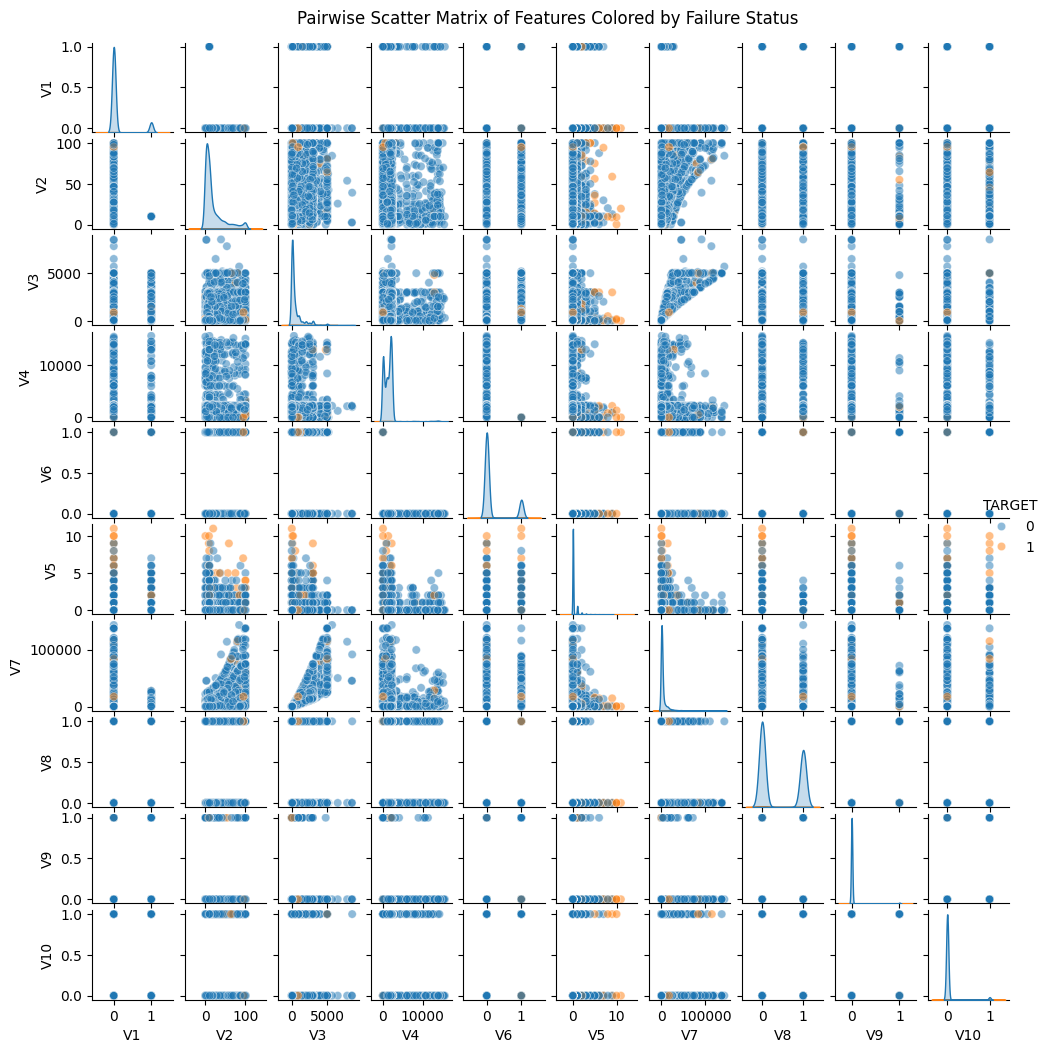

In [ ]:
plot_size = 10

# Create the scatter matrix
g = sns.pairplot(df, vars=numerical_features, hue='TARGET', plot_kws={'alpha': 0.5})
g.fig.suptitle("Pairwise Scatter Matrix of Features Colored by Failure Status", y=1.02)

g.fig.set_size_inches(10, 10)

plt.show()

The following code generates a bar plot to visualize the relationship between a boolean feature (in this case, `V1`, but it can be modified) and the target variable (`TARGET`). By grouping the data by the boolean feature and calculating the mean of the target variable within each group, we can assess the proportion of `TARGET = 1` for each category of the boolean feature. This plot helps to understand how the feature influences the target distribution, providing insight into its potential importance for classification models.


In [ ]:
# boolean features V1, V6, V8, V9, V10
feature_nm = 'V1'

# Bar plot for feature_1 vs target
fig = px.bar(
    df.groupby(feature_nm)["TARGET"].mean().reset_index(),
    x=feature_nm,
    y="TARGET",
    labels={"target": "Proportion of Target = 1", "feature_1": "Feature 1"},
    title=f"Relationship between {feature_nm} and Target"
)
fig.show()

The Chi-Square test is used to evaluate if there is a significant association between two categorical variables—in this case, the boolean feature `V1` and the target variable `TARGET`. The contingency table created here summarizes the frequency distribution of the categorical variables, and the Chi-Square test checks whether the observed distribution significantly differs from the expected distribution under the assumption of independence.

All features (`V1`, `V6`, `V8`, `V9`, and `V10`) show very low p-values (all less than 0.05), indicating that they are statistically significantly associated with the target variable `TARGET`.

The high chi-square values and very small p-values suggest that these features provide meaningful information in predicting the target. However, since the test assumes sufficient sample size in each category for accurate statistical inference. With such a low number of `TARGET = 1` instances, as expected  the frequency for the contingency table may be very small, what can lead to inaccurate p-values.






In [ ]:
results_chi2 = []
for feature in boolean_features:
  df_chi2 = df.dropna(subset=[feature])

  # Create a contingency table
  contingency_table = pd.crosstab(df_chi2[feature], df_chi2['TARGET'])

  # Perform Chi-Square test
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  results_chi2.append([feature,chi2, p, dof, expected])

results_df_chi2 = pd.DataFrame(results_chi2, columns=['Feature','chi2', 'p', 'dof', 'expected'])
results_df_chi2

,Feature,chi2,p,dof,expected
0,V1,15.853381,6.844414e-05,1,"[[9222.347992718214, 103.65200728178596], [109..."
1,V6,42.461482,7.208796e-11,1,"[[9083.348374966425, 98.65162503357507], [1965..."
2,V8,32.479105,1.204810e-08,1,"[[6449.503742722484, 70.49625727751594], [4254..."
3,V9,29.921933,4.497960e-08,1,"[[10844.022429230352, 117.97757076964818], [93..."
4,V10,27.535850,1.542094e-07,1,"[[10711.663712060166, 116.33628793983347], [33..."


The Mutual Information (MI) score quantifies the amount of information shared between each feature and the target variable. It measures the dependency between two variables, indicating how much knowing the value of one feature reduces uncertainty about the target. MI is particularly useful in identifying non-linear relationships between features and the target, unlike correlation which only captures linear relationships.

Key Points
- Importance of MI: Higher mutual information values indicate a stronger relationship between a feature and the target. This can guide feature selection by highlighting features that provide the most information for predicting the target variable.
- Ranking Features: Features like `V5` and `V2` show higher mutual information scores, indicating they have stronger associations with the target variable. In contrast, features like `V1` and `V10` have very low or zero mutual information, suggesting they may be irrelevant or redundant in predicting the target.

In [ ]:
# Extract features (X) and target (y)
X = df_clean[numerical_features]
y = df_clean['TARGET']

# Calculate mutual information between each feature and the target
mi = mutual_info_classif(X, y)

# Create a DataFrame to display the results
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})

# Sort the features by mutual information
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
mi_df

,Feature,Mutual Information
5,V5,0.010574
1,V2,0.004525
6,V7,0.004411
2,V3,0.003978
3,V4,0.002651
7,V8,0.002186
0,V1,0.001795
4,V6,0.001577
9,V10,0.001092
8,V9,0.000187


Variance is a measure of the dispersion or spread of values within a feature. A low variance indicates that the feature values are clustered around the mean, while a high variance suggests more variability. Typically, features with low variance are considered less informative, but this is not always the case, especially when interpreting feature importance in the context of the target variable.

Key Points:
- Low Variance in V5: The feature `V5` shows a low variance, which might suggest that the values of `V5` do not vary significantly across the dataset. This could lead one to initially consider it less important.
- Context from Previous Analysis: Despite its low variance, previous analysis (e.g., Mutual Information or Chi-Square test) indicates that `V5` has a strong relationship with the target variable, suggesting that it is still an important feature for the predictive model. This highlights the need to consider not just variance, but also other statistical relationships when selecting features.



In [ ]:
# Calculate variance for each feature
variances = df[continuous_features].var()
variances.sort_values()

# The feature V5 shows a low variance, however based on
# the previous analysis is possible to state that it's an
# important feature to be considered

,0
V5,4.108537e-01
V2,6.473143e+02
V3,8.219707e+05
V4,3.015747e+06
V7,1.328789e+08


The Predictive Power Score (PPS) is a metric that quantifies the ability of a feature to predict the target variable. It ranges from 0 to 1, where higher values indicate stronger predictive relationships. PPS is particularly useful for feature selection in machine learning tasks, as it provides an objective measure of how well each feature contributes to predicting the target.

Key Results:
- Features like `V5` have a high PPS (0.113825), indicating that it is a strong predictor for the target variable.
- Other features like `V6`, `V8`, and `V10` have very low PPS values, suggesting that they may not be very informative for predicting the target.edge and other evaluation metrics to make final feature selection decisions.


In [ ]:
def get_ppscore(df, drop_cols):
  df_ppscore = df.drop(columns=drop_cols).copy()
  df_ppscore['TARGET'] = df['TARGET'].astype('boolean')
  return pps.predictors(df_ppscore, "TARGET")

drop_cols = ['SAFRA', 'V11','V12','CEP']
get_ppscore(df, drop_cols)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V5,TARGET,0.113825,classification,True,weighted F1,0.983829,0.985670,DecisionTreeClassifier()
1,V6,TARGET,0.000002,classification,True,weighted F1,0.983530,0.983530,DecisionTreeClassifier()
2,V8,TARGET,0.000002,classification,True,weighted F1,0.983530,0.983530,DecisionTreeClassifier()
3,V10,TARGET,0.000002,classification,True,weighted F1,0.983530,0.983530,DecisionTreeClassifier()
4,V1,TARGET,0.000000,classification,True,weighted F1,0.983232,0.983232,DecisionTreeClassifier()
5,V2,TARGET,0.000000,classification,True,weighted F1,0.984427,0.983526,DecisionTreeClassifier()
6,V3,TARGET,0.000000,classification,True,weighted F1,0.983530,0.981727,DecisionTreeClassifier()
7,V4,TARGET,0.000000,classification,True,weighted F1,0.983530,0.983030,DecisionTreeClassifier()
8,V7,TARGET,0.000000,classification,True,weighted F1,0.982634,0.979726,DecisionTreeClassifier()
9,V9,TARGET,0.000000,classification,True,weighted F1,0.984427,0.984427,DecisionTreeClassifier()


Multicollinearity refers to a situation where two or more features in a dataset are highly correlated, making it difficult to isolate the individual effect of each feature on the target variable. This can lead to problems in model interpretation and stability, especially in linear regression models where coefficients may become unreliable.

Key results:
- All features in the dataset have relatively low VIF values, with the highest being `V7` (3.77).
- Features such as `V1`, `V2`, and `V5` have VIFs close to 1, indicating minimal multicollinearity.
- Based on the VIF results, there is no immediate concern for multicollinearity, as none of the values exceed typical thresholds (e.g., 5 or 10), suggesting that the features are not highly correlated with each other.

In [ ]:
# Checking multicolinearity
def check_multicollinearity(df, drop_cols):
  df_vif = df.drop(columns=drop_cols)
  df_vif = df_vif.dropna()
  df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_vif), columns=df_vif.columns)

  vif_data = pd.DataFrame()
  vif_data["feature"] = df_scaled.columns
  vif_data["VIF"] = [variance_inflation_factor(df_scaled.values, i) for i in range(len(df_scaled.columns))]
  return vif_data

drop_cols = ['SAFRA', 'V11','V12','CEP', 'TARGET']
check_multicollinearity(df, drop_cols)

,feature,VIF
0,V1,1.084646
1,V2,1.433770
2,V3,3.267572
3,V4,1.186838
4,V5,1.051906
5,V6,1.174061
6,V7,3.772701
7,V8,1.136518
8,V9,1.004171
9,V10,1.018381


The Population Stability Index (PSI) is used to assess how much a feature's distribution has changed between two datasets, such as training and out-of-time (OOT) datasets. It is commonly applied in model monitoring to track feature stability over time. A high PSI indicates that the feature's distribution has shifted significantly, while a low PSI suggests that the feature distribution is stable.

- Thresholds for PSI: Generally, PSI values are interpreted as follows:
  - PSI < 0.1: No significant shift in the distribution.
  - PSI between 0.1 and 0.2: Mild shift in the distribution.
  - PSI > 0.2: Significant shift, indicating that the feature may no longer be reliable for predictions.

Key points:
- The PSI values for the features `V2`, `V3`, `V4`, `V5`, and `V7` are all very low, indicating minimal shifts between the training and out-of-time (OOT) datasets. This suggests that these features are stable over time and their distributions have not changed significantly.




In [ ]:
def calculate_psi(expected, actual, bins=10):
    """
    Calculate the Population Stability Index (PSI) between two datasets.

    Parameters:
        expected (array-like): Baseline (expected) dataset.
        actual (array-like): Current (actual) dataset.
        bins (int): Number of bins to divide the data into.

    Returns:
        float: The PSI value.
    """
    # Create bins based on the expected data
    breaks = np.linspace(expected.min(), expected.max(), bins + 1)

    # Count the occurrences in each bin for both datasets
    expected_bin_counts = np.histogram(expected, bins=breaks)[0]
    actual_bin_counts = np.histogram(actual, bins=breaks)[0]

    # Convert counts to proportions
    expected_proportions = expected_bin_counts / len(expected)
    actual_proportions = actual_bin_counts / len(actual)

    # Avoid division by zero or log of zero by adding a small value
    epsilon = 1e-10
    expected_proportions = np.clip(expected_proportions, epsilon, None)
    actual_proportions = np.clip(actual_proportions, epsilon, None)

    # Calculate PSI
    psi = np.sum((expected_proportions - actual_proportions) *
                 np.log(expected_proportions / actual_proportions))
    return psi

# Feature stability by SAFRA
dist_train = df[~df['SAFRA'].isin([201911, 201912])].copy()
dist_oot = df[df['SAFRA'].isin([201911, 201912])].copy()

for feature in continuous_features:
    psi = calculate_psi(dist_train[feature], dist_oot[feature])
    print(f"PSI for {feature}: {psi}")

PSI for V2: 0.0018932077060992837
PSI for V3: 0.010579024799381902
PSI for V4: 0.009754042300571055
PSI for V5: 0.021569087430881755
PSI for V7: 0.0236431066338682


Key points:

- MG: feature `V4` shows a mild shift in the distribution
- ES: `V4` and `V7` shows a mild shift in the distribution

In [ ]:
for state in ['SP', 'RJ', 'MG', 'ES']:
  # Feature stability by SAFRA
  dist_train = df[~df['SAFRA'].isin([201911, 201912])].copy()
  dist_train = dist_train[dist_train['V11']==state]
  dist_oot = df[df['SAFRA'].isin([201911, 201912])].copy()
  dist_oot = dist_oot[dist_oot['V11']==state]

  for feature in continuous_features:
      psi = calculate_psi(dist_train[feature], dist_oot[feature])
      print(f"{state} - PSI for {feature}: {psi}")

SP - PSI for V2: 0.008639864804330863
SP - PSI for V3: 0.008269676941658132
SP - PSI for V4: 0.02149964425595187
SP - PSI for V5: 0.03118156487998931
SP - PSI for V7: 0.06242474704575057
RJ - PSI for V2: 0.01693028669993808
RJ - PSI for V3: 0.0681880681639708
RJ - PSI for V4: 0.06301785032981683
RJ - PSI for V5: 0.03398121485358443
RJ - PSI for V7: 0.06000191578849409
MG - PSI for V2: 0.022841705946295133
MG - PSI for V3: 0.03211465155138575
MG - PSI for V4: 0.15158963175073548
MG - PSI for V5: 0.04715117277141817
MG - PSI for V7: 0.09159122164435071
ES - PSI for V2: 0.0271027814343774
ES - PSI for V3: 0.04460927918864366
ES - PSI for V4: 0.14983653999116583
ES - PSI for V5: 0.09462513005169573
ES - PSI for V7: 0.18949910093093184


In [ ]:
def calculate_boolean_psi(expected, actual):
    """
    Calculate PSI for boolean features by treating True/False as categories.
    """
    expected_proportions = expected.value_counts(normalize=True)
    actual_proportions = actual.value_counts(normalize=True)

    # Ensure both have all categories (True and False)
    categories = [True, False]
    expected_proportions = expected_proportions.reindex(categories, fill_value=0)
    actual_proportions = actual_proportions.reindex(categories, fill_value=0)

    psi = np.sum((expected_proportions - actual_proportions) *
                 np.log((expected_proportions + 1e-10) / (actual_proportions + 1e-10)))
    return psi

dist_train = df[~df['SAFRA'].isin([201911, 201912])].copy()
dist_oot = df[df['SAFRA'].isin([201911, 201912])].copy()
for feature in boolean_features:
    psi = calculate_boolean_psi(dist_train[feature], dist_oot[feature])
    print(f"PSI for {feature}: {psi}")

PSI for V1: 0.0
PSI for V6: 0.0
PSI for V8: 0.0
PSI for V9: 0.0
PSI for V10: 0.0


In [ ]:
for state in ['SP', 'RJ', 'MG', 'ES']:
  # Feature stability by SAFRA
  dist_train =  df[~df['SAFRA'].isin([201911, 201912])].copy()
  dist_train = dist_train[dist_train['V11']==state]
  dist_oot =  df[df['SAFRA'].isin([201911, 201912])].copy()
  dist_oot = dist_oot[dist_oot['V11']==state]

  for feature in boolean_features:
      psi = calculate_psi(dist_train[feature], dist_oot[feature])
      psi = round(psi, 4)
      print(f"{state} - PSI for {feature}: {psi}")

SP - PSI for V1: 0.0
SP - PSI for V6: 0.0001
SP - PSI for V8: 0.0002
SP - PSI for V9: 0.0076
SP - PSI for V10: 0.0013
RJ - PSI for V1: 0.0013
RJ - PSI for V6: 0.005
RJ - PSI for V8: 0.0023
RJ - PSI for V9: 0.0019
RJ - PSI for V10: 0.0018
MG - PSI for V1: 0.0091
MG - PSI for V6: 0.0021
MG - PSI for V8: 0.007
MG - PSI for V9: 0.0043
MG - PSI for V10: 0.0004
ES - PSI for V1: 0.0024
ES - PSI for V6: 0.0019
ES - PSI for V8: 0.0022
ES - PSI for V9: 0.0003
ES - PSI for V10: 0.0024


## Feature engineering

**Handling categorical features**

One-hot encoding is a method for converting categorical variables into a numerical format, which is essential for many machine learning algorithms that require numerical input. It creates a new binary column for each category (state in this case) and assigns a `1` if the record belongs to that category, and `0` otherwise.

Since the categorical feature `V11` has only 4 possible states, one-hot encoding is an appropriate technique to represent these categories numerically.

After applying one-hot encoding, the categorical feature `V11` will be expanded into multiple binary columns, each representing a state. This transformation will help in using these features as inputs for the model without imposing any unintended order or numerical relationships on them.



In [ ]:
# Handling categorical features
# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=['V11'], dtype=float)
df_encoded

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V12,CEP,TARGET,V11_ES,V11_MG,V11_RJ,V11_SP
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,0,São Paulo,8412006,0,0.0,0.0,0.0,1.0
1,201910,0.0,4.4,35.00,1369,0.0,0,63.98,1.0,0.0,0,Rio de Janeiro,23580304,0,0.0,0.0,1.0,0.0
2,201906,0.0,0.7,52.99,1228,0.0,0,98.84,0.0,0.0,0,Belo Horizonte,30421310,0,0.0,1.0,0.0,0.0
3,201910,0.0,63.3,810.00,0,0.0,1,9237.21,0.0,0.0,0,São Paulo,8253410,0,0.0,0.0,0.0,1.0
4,201902,0.0,4.1,17.50,0,0.0,1,27.70,1.0,0.0,0,Vitória,29017186,0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11164,201909,0.0,86.4,5.00,1964,0.0,0,31.57,1.0,0.0,0,Vila Velha,29101566,0,1.0,0.0,0.0,0.0
11165,201909,0.0,6.7,55.00,0,0.0,1,114.51,0.0,0.0,0,Cariacica,29149650,0,1.0,0.0,0.0,0.0
11166,201901,0.0,1.2,100.00,1120,0.0,0,213.57,1.0,0.0,0,São Paulo,8253410,0,0.0,0.0,0.0,1.0
11167,201911,0.0,11.0,85.00,2005,0.0,0,208.33,0.0,0.0,0,Sorocaba,18020020,0,0.0,0.0,0.0,1.0


In [ ]:
# Since the dataset has a time frequency, for the model development
# the dataset is split into train and test (out-of-time)
train = df_encoded[df_encoded['SAFRA'] < 201911]
oot = df_encoded[df_encoded['SAFRA'] >= 201911]

**Transforming States into Clusters with KMeans for Model Input**

In this section of the code, KMeans clustering is applied to group cities based on their 'positive rate' and 'volume' into distinct clusters. This transformation aims to capture the underlying patterns within the cities that may not be obvious from the raw categorical data, it's an attempt of improving the model's ability to learn complex relationships.

The transformed `train_transformed` and `oot_transformed` datasets now contain a new feature (`city_cluster`) that indicates the cluster assignment for each city. This feature can now be used in the model to help make more informed predictions.


In [ ]:
scaler = StandardScaler()

city_agg = train.groupby('V12')['TARGET'].agg(['mean', 'count']).reset_index()
city_agg.columns = ['city','pos_rate', 'volume']

city_agg_scaled = scaler.fit_transform(city_agg[['pos_rate', 'volume']])
city_agg_scaled = pd.DataFrame(city_agg_scaled, columns=['pos_rate', 'volume'])
city_agg_scaled

,pos_rate,volume
0,0.720285,-0.560545
1,-0.157169,0.827662
2,1.023874,-0.395163
3,-1.072445,-0.236463
4,0.755327,-0.350059
5,0.091352,-0.325001
6,-0.793499,-0.443608
7,-1.522358,-0.487042
8,-0.386474,-0.134561
9,3.094848,-0.408527


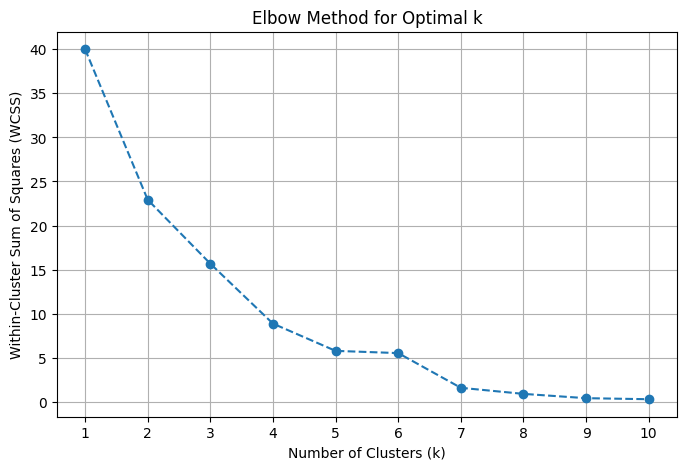

In [ ]:
wcss = []
max_clusters = 10  # Set the maximum number of clusters to test

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(city_agg_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

In [ ]:
city_agg_scaled['city_cluster'] = KMeans(n_clusters=5).fit_predict(
  city_agg_scaled
)
city_agg_scaled = pd.concat([city_agg[['city']], city_agg_scaled], axis=1)
city_agg_scaled

,city,pos_rate,volume,city_cluster
0,Belford Roxo,0.720285,-0.560545,3
1,Belo Horizonte,-0.157169,0.827662,0
2,Betim,1.023874,-0.395163,3
3,Campinas,-1.072445,-0.236463,2
4,Cariacica,0.755327,-0.350059,3
5,Contagem,0.091352,-0.325001,4
6,Duque de Caxias,-0.793499,-0.443608,2
7,Guarapari,-1.522358,-0.487042,2
8,Guarulhos,-0.386474,-0.134561,4
9,Juiz de Fora,3.094848,-0.408527,3


In [ ]:
train_transformed = train.merge(city_agg_scaled[['city','city_cluster']], left_on='V12', right_on='city', how='left')
oot_transformed = oot.merge(city_agg_scaled[['city','city_cluster']], left_on='V12', right_on='city', how='left')

**Interaction between V5 and Other Numerical Features**

The following code I feature engineering by creating new interaction features between the existing feature `V5` and the other numerical features in the dataset.

By creating interaction features between `V5` and other numerical variables, it's an attempt to allow the model to capture potential nonlinear relationships between these variables.



In [ ]:
for feature in numerical_features:
  train_transformed[f'V5_{feature}'] = train_transformed['V5'] * train_transformed[feature]
  oot_transformed[f'V5_{feature}'] = oot_transformed['V5'] * oot_transformed[feature]

train_transformed

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V5_V1,V5_V2,V5_V3,V5_V4,V5_V6,V5_V5,V5_V7,V5_V8,V5_V9,V5_V10
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,201910,0.0,4.4,35.00,1369,0.0,0,63.98,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,201906,0.0,0.7,52.99,1228,0.0,0,98.84,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,201910,0.0,63.3,810.00,0,0.0,1,9237.21,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,201902,0.0,4.1,17.50,0,0.0,1,27.70,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9306,201906,0.0,17.5,10.00,1967,NaN,0,18.00,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9307,201909,0.0,86.4,5.00,1964,0.0,0,31.57,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9308,201909,0.0,6.7,55.00,0,0.0,1,114.51,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9309,201901,0.0,1.2,100.00,1120,0.0,0,213.57,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Squared Features**

The following code is an approach to help the model learn complex, nonlinear relationships between the input features and the target.


In [ ]:
for feature in ['V2','V3','V5','V7']:
  train_transformed[f'{feature}_sqrt'] = train_transformed[feature] * train_transformed[feature]
  oot_transformed[f'{feature}_sqrt'] = oot_transformed[feature] * oot_transformed[feature]

train_transformed

,SAFRA,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V5_V6,V5_V5,V5_V7,V5_V8,V5_V9,V5_V10,V2_sqrt,V3_sqrt,V5_sqrt,V7_sqrt
0,201901,NaN,8.1,9.99,1968,0.0,0,15.15,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,65.61,9.980010e+01,0.0,2.295225e+02
1,201910,0.0,4.4,35.00,1369,0.0,0,63.98,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.36,1.225000e+03,0.0,4.093440e+03
2,201906,0.0,0.7,52.99,1228,0.0,0,98.84,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.49,2.807940e+03,0.0,9.769346e+03
3,201910,0.0,63.3,810.00,0,0.0,1,9237.21,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4006.89,6.561000e+05,0.0,8.532605e+07
4,201902,0.0,4.1,17.50,0,0.0,1,27.70,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.81,3.062500e+02,0.0,7.672900e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9306,201906,0.0,17.5,10.00,1967,NaN,0,18.00,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,306.25,1.000000e+02,NaN,3.240000e+02
9307,201909,0.0,86.4,5.00,1964,0.0,0,31.57,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7464.96,2.500000e+01,0.0,9.966649e+02
9308,201909,0.0,6.7,55.00,0,0.0,1,114.51,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,44.89,3.025000e+03,0.0,1.311254e+04
9309,201901,0.0,1.2,100.00,1120,0.0,0,213.57,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.44,1.000000e+04,0.0,4.561214e+04


**Feature Transformation Based on Distribution of V5**

In the following code I apply a conditional transformation to the feature `V5` based on its distribution, specifically focusing on cases where the value of `V5` is greater than 3.

**Why Transform `V5` Based on Distribution?**:
  - The transformation was motivated by analyzing the distribution of `V5` and its relationship with the target variable. It was observed that values of `V5` above a certain threshold (in this case, 3) may have a different relationship with the target, suggesting a need for nonlinear transformation for those values to improve model performance.
  - **Capturing Extreme Values**: Squaring values above 3 accentuates the differences between larger values, allowing the model to capture potentially important patterns that are not apparent when using the raw values alone.

**Impact on Model**:
   - This transformation is intended to enhance the model's ability to distinguish between different ranges of `V5`. By squaring values above 3, we create a higher distinction between larger values of `V5`, which might be important for predicting the target variable, especially if these larger values are associated with a specific class of the target

In [ ]:
train_transformed['V5_transformed'] = train_transformed['V5'].apply(lambda x: x*x if x>3 else x)
oot_transformed['V5_transformed'] = oot_transformed['V5'].apply(lambda x: x*x if x>3 else x)

In [ ]:
test_features = ['V2_sqrt','V3_sqrt'	,'V5_sqrt'	,'V7_sqrt']
plot_boxplots(train_transformed, test_features)

In [ ]:
drop_cols = ['SAFRA','V12','CEP','city']
get_ppscore(train_transformed, drop_cols)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V5_V7,TARGET,0.063443,classification,True,weighted F1,0.987119,0.987936,DecisionTreeClassifier()
1,V3,TARGET,0.018081,classification,True,weighted F1,0.984427,0.984709,DecisionTreeClassifier()
2,V3_sqrt,TARGET,0.018081,classification,True,weighted F1,0.984427,0.984709,DecisionTreeClassifier()
3,V5_V10,TARGET,0.016523,classification,True,weighted F1,0.983530,0.983803,DecisionTreeClassifier()
4,V5,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
5,V5_V5,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
6,V5_sqrt,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
7,V5_transformed,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
8,V9,TARGET,0.000003,classification,True,weighted F1,0.986221,0.986221,DecisionTreeClassifier()
9,V8,TARGET,0.000002,classification,True,weighted F1,0.982634,0.982634,DecisionTreeClassifier()


**Feature Selection Using Recursive Feature Elimination with Cross-Validation (RFECV)**

The following code apply Recursive Feature Elimination with Cross-Validation (RFECV) to select the most important features for the model. The goal is to reduce the number of features by iteratively removing the least important ones, while keeping track of performance during cross-validation. This process helps identify the optimal subset of features that contribute the most to the model's predictive power.

**Key points**
- Selected Features: These features are deemed the most important based on the RFECV ranking and will be used in the final model. Features like `V1`, `V2`, `V3`, `V5`, `V6`, `V7`, `V8`, and several others are highly ranked and selected for further use.
- Dropped Features: Features with higher rankings (such as `V4`, `V11_SP`, and other `V5_*` features) were deemed less important and thus excluded from the final model. These features are likely to contribute less predictive value based on the RFECV results.




In [ ]:
def feature_selection_rfecv(train, features, model_nm='RF', step= 1, cv=3):
  X_train = train[features]
  y_train = train['TARGET']

  # Models
  scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

  models = {
    'RF': RandomForestClassifier(class_weight='balanced', random_state=10),
    'LR': LogisticRegression(random_state=41),
    'LR_b': LogisticRegression(class_weight='balanced', random_state=42),
    'XGB': xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, objective='binary:logistic'),
  }
  model = models[model_nm]
  # Initialize the RFECV (using cross-validation)
  selector = RFECV(estimator=model, step=step, cv=cv)

  # Define the pipeline
  pipeline = Pipeline([
      ('imputer', KNNImputer(n_neighbors=3, weights="uniform")),
      ('scaler', StandardScaler())
  ])

  # Fit the pipeline to the training data and transform it
  X_train_transformed = pipeline.fit_transform(X_train)

  # Fit the RFECV to the training data
  selector.fit(X_train_transformed, y_train)
  rfecv_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': selector.ranking_,
    'Selected': selector.support_
  })

  return rfecv_df

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
            'V11_ES', 'V11_MG', 'V11_RJ', 'V11_SP', 'V5_V1','V5_V2',
            'V5_V3', 'V5_V4', 'V5_V6', 'V5_V5', 'V5_V7', 'V5_V8',
            'V5_V9','V5_V10', 'V2_sqrt', 'V3_sqrt', 'V5_sqrt',
            'V7_sqrt']

rfecv_df = feature_selection_rfecv(train_transformed, features, model_nm='LR', step= 1, cv=5)
rfecv_df

,Feature,Ranking,Selected
0,V1,1,True
1,V2,1,True
2,V3,1,True
3,V4,6,False
4,V5,1,True
5,V6,1,True
6,V7,1,True
7,V8,1,True
8,V9,1,True
9,V10,1,True


In [ ]:
rfecv_features = list(rfecv_df[rfecv_df['Selected']==True]['Feature'].values) + ['TARGET']

# Model development

In [ ]:
# Function to calculate J-point for optimal threshold
def j_point(y_true, y_pred_proba):
    """
    Calculate the J-point for the optimal threshold, which maximizes the difference
    between true positive rate (TPR) and false positive rate (FPR) from a ROC curve.

    Parameters:
    y_true (array-like): True binary labels.
    y_pred_proba (array-like): Predicted probabilities for the positive class.

    Returns:
    tuple: The optimal threshold, FPR at the optimal threshold, and TPR at the optimal threshold.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr
    j_index = np.argmax(j_scores)
    optimal_threshold = thresholds[j_index]
    return optimal_threshold, fpr[j_index], tpr[j_index]

def ks_stat(y, yhat):
    """
    Calculate the Kolmogorov-Smirnov (KS) statistic between the predicted scores
    of positive and negative classes.

    Parameters:
    y (array-like): True binary labels.
    yhat (array-like): Predicted probabilities or scores.

    Returns:
    float: KS statistic between the predicted scores of positive and negative classes.
           Returns NaN if either class has no predictions.
    """
    # Convert pd.Series to numpy.ndarray if necessary
    if isinstance(y, pd.Series):
        y = y.values
    if isinstance(yhat, pd.Series):
        yhat = yhat.values

    # Ensure y is a 1-dimensional array for boolean indexing
    y = np.ravel(y)
    yhat = np.ravel(yhat)

    # Check if the arrays after filtering are empty
    pos = yhat[y == 1]
    neg = yhat[y != 1]
    if pos.size == 0 or neg.size == 0:
        return np.nan

    return stats.ks_2samp(pos, neg).statistic

# Function to compute metrics
def compute_metrics(y_true, y_pred_proba, threshold):
    """
    Compute various evaluation metrics for classification, including F1 score,
    accuracy, precision, recall, ROC AUC, PR AUC, KS statistic, and Brier score.

    Parameters:
    y_true (array-like): True binary labels.
    y_pred_proba (array-like): Predicted probabilities for the positive class.
    threshold (float): The threshold for converting predicted probabilities to binary labels.

    Returns:
    pd.DataFrame: DataFrame containing the computed metrics.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)

    f1score = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    brier_score = brier_score_loss(y_true,y_pred_proba)

    precision_2, recall_2, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall_2, precision_2)
    ks_score = ks_stat(y_true,y_pred_proba)

    metrics = {
        'f1_score': f1score,
        'accuracy': accuracy,
        'precision': precision,
        'fpr': np.sum(y_pred * (1 - y_true)) / np.sum(1 - y_true) if np.sum(1 - y_true) != 0 else 0,
        'fnr': np.sum((1 - y_pred) * y_true) / np.sum(y_true) if np.sum(y_true) != 0 else 0,
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'pr_auc': pr_auc,
        'ks': ks_stat(y_true, y_pred),
        'brier': brier_score_loss(y_true, y_pred_proba),
    }

    metrics_df = pd.DataFrame(metrics, index=[0])
    return metrics_df

def split_dataset(df, state=None):
    """
    Split the dataset into training and testing sets based on the value of the 'V11' column.

    Parameters:
    df (pd.DataFrame): The dataset to be split.
    state (optional): The value of 'V11' column used to separate the dataset. Default is None.

    Returns:
    tuple: Two DataFrames - the training set and the testing set.
    """
    train = df[df['V11'] != state]
    test = df[df['V11'] == state]
    return train, test

def plot_metrics_comparison(all_models_test):
    """
    Plot a comparison of model evaluation metrics for multiple models.

    Parameters:
    all_models_test (pd.DataFrame): DataFrame containing the metrics for each model.
                                     The last two columns should not be metrics.

    Returns:
    None: Displays a plot with comparisons of different metrics for each model.
    """
    # Extract metrics and categories
    categories = all_models_test["model"]
    metrics = all_models_test.columns[:-2]  # Skip the 'Category' column

    # Create subplots: 2 subplots per row
    fig = make_subplots(
        rows=(len(metrics) + 1) // 2,  # Calculate the number of rows needed
        cols=2,  # Two subplots per row
        subplot_titles=metrics
    )

    # Add a bar plot for each metric
    for i, metric in enumerate(metrics):
        row = i // 2 + 1  # Row index (1-based)
        col = i % 2 + 1   # Column index (1-based)
        fig.add_trace(
            go.Bar(
                x=categories,
                y=all_models_test[metric],
                name=metric
            ),
            row=row, col=col
        )

    # Update layout
    fig.update_layout(
        height=1200, width=900,
        title="Comparison of Metrics by Model",
        barmode="group",
        showlegend=False  # Adjust as needed
    )

    # Show the plot
    fig.show()


## Version 1 (benchmark) - Out of time

Train an initial model using the raw dataset features without any feature engineering, applying only imputation and scaling. The primary objective is to establish this model as a benchmark for comparison with future versions that will incorporate feature engineering and resampling techniques. For model development, the test dataset will be out-of-time (OOT), representing the last two months of data.




In [ ]:
def run_benchmark_model(train, oot, model_nm):
  """
  Train a benchmark classification model using the specified algorithm and evaluate its performance
  on both training and out-of-time (OOT) datasets. The model is trained using a pipeline with
  imputation and scaling applied to the features.

  Parameters:
  train (pd.DataFrame): The training dataset containing the features and target variable ('TARGET').
  oot (pd.DataFrame): The out-of-time (OOT) dataset for testing the model's performance.
  model_nm (str): The name of the model to be used for training. Options are 'RF', 'LR', 'LGB', and 'XGB'.

  Returns:
  pd.DataFrame: A DataFrame containing the evaluation metrics for both the training and OOT datasets.
                The DataFrame includes columns for metrics like F1 score, accuracy, ROC AUC, etc.,
  """
  X_train = train.drop(columns='TARGET')
  y_train =  train['TARGET']

  X_test = oot.drop(columns='TARGET')
  y_test =  oot['TARGET']

  # Define the pipeline
  pipeline = Pipeline([
      ('imputer', KNNImputer(n_neighbors=3, weights="uniform")),
      ('scaler', StandardScaler())
  ])

  # Fit the pipeline to the training data and transform it
  X_train_transformed = pipeline.fit_transform(X_train)
  X_test_transformed = pipeline.transform(X_test)

  # Models
  scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

  models = {
    'RF': RandomForestClassifier(class_weight='balanced', random_state=10),
    'LR': LogisticRegression(class_weight='balanced', random_state=42),
    'LGB': lgb.LGBMClassifier(is_unbalance=True),
    'XGB': xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, objective='binary:logistic'),
  }

  # get training time
  t0 = time.time()
  model = models[model_nm]
  model.fit(X_train_transformed, y_train)
  t1 = time.time()
  training_time = round(t1-t0,5)

  y_train_proba = model.predict_proba(X_train_transformed)[:, 1]
  y_test_proba = model.predict_proba(X_test_transformed)[:, 1]

  optimal_threshold = j_point(y_train, y_train_proba)[0]

  metrics_train = compute_metrics(y_train, y_train_proba, optimal_threshold)
  metrics_test = compute_metrics(y_test, y_test_proba, optimal_threshold)

  metrics_train[['type','model','training_time']] = ['train',model_nm, training_time]
  metrics_test[['type','model','training_time']] = ['test',model_nm, training_time]

  df_metrics = pd.concat([metrics_train, metrics_test])

  return df_metrics

In [ ]:
# Since the first version is to get a basic version, it'll be used the initial
# features of the dataset
selected_features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','TARGET']

df_train = train[selected_features]
df_oot = oot[selected_features]

In [ ]:
# Training all models
all_models = pd.DataFrame()
models_list = ['RF','LR','LGB','XGB']
for model in models_list:
  df_metrics = run_benchmark_model(df_train, df_oot, model_nm=model)
  all_models = pd.concat([all_models, df_metrics])

[LightGBM] [Info] Number of positive: 98, number of negative: 9213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1054
[LightGBM] [Info] Number of data points in the train set: 9311, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010525 -> initscore=-4.543403
[LightGBM] [Info] Start training from score -4.543403


### Model Evaluation Summary

it's evaluated the performance of four models on the test set: **Logistic Regression (LR)**, **Random Forest (RF)**, **LightGBM (LGB)**, and **XGBoost (XGB)**. Below are the key findings based on several evaluation metrics:

- **Recall** is the most important metric due to the imabanlance dataset. All models have low recall, indicating that they miss a significant number of positive cases.
- **Logistic Regression (LR)** performs better in terms of recall, but at the cost of precision, leading to many false positives.
- **XGBoost (XGB)** shows a slight improvement over Random Forest and LightGBM in recall, but the recall is still too low for effective positive class detection.


In [ ]:
all_models_test = all_models[all_models['type']=='test']
all_models_test

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,model,training_time
0,0.166667,0.989236,1.000000,0.000000,0.909091,0.090909,0.679454,0.177148,0.090909,0.010813,test,RF,0.89727
0,0.059441,0.710441,0.030909,0.290305,0.227273,0.772727,0.773173,0.116604,0.482422,0.141529,test,LR,0.01756
0,0.160000,0.988698,0.666667,0.000545,0.909091,0.090909,0.748737,0.207697,0.090364,0.015051,test,LGB,0.22896
0,0.240000,0.989774,1.000000,0.000000,0.863636,0.136364,0.775339,0.215464,0.136364,0.012852,test,XGB,0.19903


In [ ]:
# Plot metrics comparison
plot_metrics_comparison(all_models_test)

## Version 2 - Feature engineering

In this version, the new features generated in the "Feature Engineering" section are incorporated into the model development.

In [ ]:
# Checking the predictive power using ppscore
drop_cols = ['SAFRA','V12','CEP','city']
get_ppscore(train_transformed, drop_cols)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V5_V7,TARGET,0.063443,classification,True,weighted F1,0.987119,0.987936,DecisionTreeClassifier()
1,V3,TARGET,0.018081,classification,True,weighted F1,0.984427,0.984709,DecisionTreeClassifier()
2,V3_sqrt,TARGET,0.018081,classification,True,weighted F1,0.984427,0.984709,DecisionTreeClassifier()
3,V5_V10,TARGET,0.016523,classification,True,weighted F1,0.983530,0.983803,DecisionTreeClassifier()
4,V5,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
5,V5_V5,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
6,V5_sqrt,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
7,V5_transformed,TARGET,0.016412,classification,True,weighted F1,0.983530,0.983801,DecisionTreeClassifier()
8,V9,TARGET,0.000003,classification,True,weighted F1,0.986221,0.986221,DecisionTreeClassifier()
9,V8,TARGET,0.000002,classification,True,weighted F1,0.982634,0.982634,DecisionTreeClassifier()


The RFECV is re-applied to incorporate the new features and identify the most important ones for use in the model.

In [ ]:
# Applying feature selection
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
            'V11_ES', 'V11_MG', 'V11_RJ', 'V11_SP','city_cluster','V5_V1','V5_V2',
            'V5_V3', 'V5_V4', 'V5_V6', 'V5_V7', 'V5_V8',
            'V5_V9','V5_V10', 'V2_sqrt', 'V3_sqrt', 'V5_sqrt',
            'V7_sqrt','V5_transformed']

rfecv_df = feature_selection_rfecv(train_transformed, features, model_nm='LR', step= 1, cv=5)
rfecv_df

,Feature,Ranking,Selected
0,V1,7,False
1,V2,1,True
2,V3,1,True
3,V4,15,False
4,V5,1,True
5,V6,1,True
6,V7,1,True
7,V8,1,True
8,V9,4,False
9,V10,3,False


In [ ]:
# Filtering the features selected by RFECV
rfecv_features = list(rfecv_df[rfecv_df['Selected']==True]['Feature'].values) + ['TARGET']

df_train = train_transformed[rfecv_features]
df_oot = oot_transformed[rfecv_features]

Given the inclusion of new features, it is important to check for multicollinearity.

In [ ]:
drop_cols = [feature for feature in train_transformed.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(train_transformed, drop_cols)

,feature,VIF
0,V2,11.792122
1,V3,3.561937
2,V5,1.129959
3,V6,1.007567
4,V7,4.071794
5,V8,1.121967
6,TARGET,1.098588
7,city_cluster,1.001987
8,V2_sqrt,12.312682


In [ ]:
# Removing feature that has high VIF
rfecv_features.remove('V2_sqrt')
df_train = train_transformed[rfecv_features]
df_oot = oot_transformed[rfecv_features]

In [ ]:
# Checking again the multicollinearity to see if it's fixed
drop_cols = [feature for feature in train_transformed.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(train_transformed.drop(columns='TARGET'), drop_cols)

,feature,VIF
0,V2,1.407242
1,V3,3.157921
2,V5,1.042786
3,V6,1.004825
4,V7,3.701525
5,V8,1.121907
6,city_cluster,1.000668


In [ ]:
# Training the models
all_models_v2 = pd.DataFrame()
models_list = ['RF','LR','LGB','XGB']
for model in models_list:
  df_metrics = run_benchmark_model(df_train, df_oot, model_nm=model)
  all_models_v2 = pd.concat([all_models_v2, df_metrics])

[LightGBM] [Info] Number of positive: 98, number of negative: 9213
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 9311, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.010525 -> initscore=-4.543403
[LightGBM] [Info] Start training from score -4.543403


### Model Evaluation Summary

After incorporating and selecting new features through RFECV, the results show that recall decreased across all models. While the Logistic Regression model exhibited an improvement in ROC AUC with the new features, the recall still declined.


In [ ]:
all_models_v2_test = all_models_v2[all_models_v2['type']=='test']
all_models_v2_test

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,model,training_time
0,0.083333,0.988159,0.500000,0.000545,0.954545,0.045455,0.766724,0.186952,0.044910,0.010793,test,RF,2.44425
0,0.060120,0.747578,0.031447,0.251634,0.318182,0.681818,0.783596,0.168151,0.430184,0.150060,test,LR,0.01980
0,0.266667,0.988159,0.500000,0.002179,0.818182,0.181818,0.762626,0.172952,0.179640,0.018313,test,LGB,0.50077
0,0.160000,0.988698,0.666667,0.000545,0.909091,0.090909,0.744850,0.145148,0.090364,0.014226,test,XGB,0.89966


In [ ]:
# Plot metrics comparison
plot_metrics_comparison(all_models_v2_test)

## Version 3 - Over sampling

Given the high class imbalance, this version of the model applies over-sampling to the minority class using the SMOTETomek method. While SMOTE and SMOTEENN were also tested, SMOTETomek outperformed them.

In [ ]:
def over_sampling_data(train, oot):
  """
  Perform data preprocessing, including imputation and oversampling, on the training and out-of-time datasets.
  The function imputes missing values using KNN imputation and applies SMOTE-Tomek to address class imbalance
  in the training dataset.

  Parameters:
  train (pd.DataFrame): The training dataset containing the features and target variable ('TARGET').
  oot (pd.DataFrame): The out-of-time dataset for testing, which will also undergo imputation but not oversampling.

  Returns:
  pd.DataFrame, pd.Series, pd.DataFrame, pd.Series:
    - X_resampled: The resampled feature matrix for the training data after applying SMOTE-Tomek.
    - y_resampled: The resampled target vector for the training data.
    - X_test_imputed: The imputed feature matrix for the out-of-time test data.
    - y_test: The target vector for the out-of-time test data.
  """
  X_train = train.drop(columns=['TARGET','V12','CEP','city'])
  y_train =  train['TARGET']

  X_test = oot.drop(columns=['TARGET','V12','CEP','city'])
  y_test =  oot['TARGET']

  imputer = KNNImputer(n_neighbors=3)

  X_train_imputed = imputer.fit_transform(X_train)
  X_test_imputed = imputer.transform(X_test)

  smotetomek = SMOTETomek(random_state=42)
  X_resampled, y_resampled = smotetomek.fit_resample(X_train_imputed, y_train)


  # Convert the resampled data back to DataFrame
  X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
  X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

  return X_resampled, y_resampled, X_test_imputed, y_test

In [ ]:
X_resampled, y_resampled, X_test_imputed, y_test = over_sampling_data(train_transformed, oot_transformed)


Since the dataset was resampled, the predictive power of the features was re-evaluated. The results below show that most features have improved their predictive power.

In [ ]:
data_resampled = pd.concat([X_resampled,y_resampled], axis=1)
oot_imputed = pd.concat([X_test_imputed,y_test], axis=1)
get_ppscore(data_resampled, drop_cols=['SAFRA'])

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V5_V5,TARGET,0.772448,classification,True,weighted F1,0.5092,0.888317,DecisionTreeClassifier()
1,V5_sqrt,TARGET,0.772448,classification,True,weighted F1,0.5092,0.888317,DecisionTreeClassifier()
2,V5_transformed,TARGET,0.765761,classification,True,weighted F1,0.5092,0.885036,DecisionTreeClassifier()
3,V5,TARGET,0.763102,classification,True,weighted F1,0.5092,0.883731,DecisionTreeClassifier()
4,city_cluster,TARGET,0.759762,classification,True,weighted F1,0.5092,0.882091,DecisionTreeClassifier()
5,V5_V3,TARGET,0.681268,classification,True,weighted F1,0.5092,0.843566,DecisionTreeClassifier()
6,V5_V7,TARGET,0.664047,classification,True,weighted F1,0.5092,0.835114,DecisionTreeClassifier()
7,V5_V2,TARGET,0.650792,classification,True,weighted F1,0.5092,0.828608,DecisionTreeClassifier()
8,V2_sqrt,TARGET,0.529849,classification,True,weighted F1,0.5092,0.769250,DecisionTreeClassifier()
9,V2,TARGET,0.516869,classification,True,weighted F1,0.5092,0.762879,DecisionTreeClassifier()


With the changes in the dataset, the RFECV is applied as well.

In [ ]:
# Applying feature selection
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
            'V11_ES', 'V11_MG', 'V11_RJ', 'V11_SP','city_cluster','V5_V1','V5_V2',
            'V5_V3', 'V5_V4', 'V5_V6', 'V5_V7', 'V5_V8',
            'V5_V9','V5_V10', 'V2_sqrt', 'V3_sqrt', 'V5_sqrt',
            'V7_sqrt','V5_transformed']

rfecv_df = feature_selection_rfecv(data_resampled, features, model_nm='LR_b', step= 1, cv=5)
rfecv_df

,Feature,Ranking,Selected
0,V1,1,True
1,V2,1,True
2,V3,1,True
3,V4,3,False
4,V5,1,True
5,V6,1,True
6,V7,1,True
7,V8,4,False
8,V9,1,True
9,V10,1,True


In [ ]:
# Filtering the selected features
rfecv_features = list(rfecv_df[rfecv_df['Selected']==True]['Feature'].values) + ['TARGET']

df_train = data_resampled[rfecv_features]
df_oot = oot_imputed[rfecv_features]

In [ ]:
# Checking multicollinearity
drop_cols = [feature for feature in data_resampled.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(data_resampled.drop(columns='TARGET'), drop_cols)

,feature,VIF
0,V1,1.622583
1,V2,17.834019
2,V3,22.727416
3,V5,19.109193
4,V6,1.573691
5,V7,28.895668
6,V9,1.648763
7,V10,1.607795
8,city_cluster,1.070885
9,V5_V1,3.115514


In [ ]:
# Removing features with high multicollinearity
rfecv_features.remove('V5_sqrt')
rfecv_features.remove('V5_transformed')
rfecv_features.remove('V7')
rfecv_features.remove('V3')
rfecv_features.remove('V2_sqrt')
df_train = data_resampled[rfecv_features]
df_oot = oot_imputed[rfecv_features]

In [ ]:
# Checking if there is high VIF features
drop_cols = [feature for feature in data_resampled.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(data_resampled.drop(columns='TARGET'), drop_cols)

,feature,VIF
0,V1,1.508765
1,V2,1.170831
2,V5,7.638580
3,V6,1.469225
4,V9,1.645653
5,V10,1.553982
6,city_cluster,1.046850
7,V5_V1,2.364856
8,V5_V3,3.355276
9,V5_V6,5.542306


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

def run_oversampling_model(train, oot, model_nm):
  """
  Train a classification model on the oversampled training data and evaluate it on the out-of-time test data.
  The function applies scaling to the features and computes evaluation metrics, including the optimal threshold
  for classification. It supports multiple models such as Random Forest, Logistic Regression, LightGBM, and XGBoost.

  Parameters:
  train (pd.DataFrame): The training dataset containing the features and target variable ('TARGET').
  oot (pd.DataFrame): The out-of-time dataset for testing, which is used for evaluating the trained model.
  model_nm (str): The name of the model to use. Supported models: 'RF', 'LR', 'LGB', 'XGB'.

  Returns:
  pd.DataFrame: A DataFrame containing evaluation metrics (e.g., F1 score, accuracy, ROC AUC, etc.)
                for both training and test datasets, including the training time.
  """

  X_train = train.drop(columns='TARGET')
  y_train =  train['TARGET']

  X_test = oot.drop(columns='TARGET')
  y_test =  oot['TARGET']

  # Define the pipeline
  pipeline = Pipeline([
      ('scaler', StandardScaler())
  ])

  # Fit the pipeline to the training data and transform it
  X_train_transformed = pipeline.fit_transform(X_train)
  X_test_transformed = pipeline.transform(X_test)

  # Models
  scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

  models = {
    'RF': RandomForestClassifier(),
    'LR': LogisticRegression(),
    'LGB': lgb.LGBMClassifier(),
    'XGB': xgb.XGBClassifier(),
  }

  # get training time
  t0 = time.time()
  model = models[model_nm]
  model.fit(X_train_transformed, y_train)
  t1 = time.time()
  training_time = round(t1-t0,5)

  y_train_proba = model.predict_proba(X_train_transformed)[:, 1]
  y_test_proba = model.predict_proba(X_test_transformed)[:, 1]

  optimal_threshold = j_point(y_train, y_train_proba)[0]

  metrics_train = compute_metrics(y_train, y_train_proba, optimal_threshold)
  metrics_test = compute_metrics(y_test, y_test_proba, optimal_threshold)

  metrics_train[['type','model','training_time']] = ['train',model_nm, training_time]
  metrics_test[['type','model','training_time']] = ['test',model_nm, training_time]

  df_metrics = pd.concat([metrics_train, metrics_test])

  return df_metrics

In [ ]:
all_models_oversampling = pd.DataFrame()
models_list = ['RF','LR','LGB','XGB']
for model in models_list:
  df_metrics = run_oversampling_model(df_train, df_oot, model_nm=model)
  all_models_oversampling = pd.concat([all_models_oversampling, df_metrics])

[LightGBM] [Info] Number of positive: 8770, number of negative: 8770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3518
[LightGBM] [Info] Number of data points in the train set: 17540, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


### Model Evaluation Summary

After resampling the dataset and selecting new features using RFECV, the results show an improvement in recall for all models, except Logistic Regression. However, this improvement in recall came at the expense of the ROC AUC metric compared to `version 2`, which decreased for Random forest and LGB models, but still better than the `version 1` regarding ROC AUC. While the resampling process helped increase recall, especially for models other than Logistic Regression, the overall performance is still not satisfactory, as the recall increase was not sufficient to achieve a balanced improvement in both recall and ROC AUC.



In [ ]:
all_models_oversampling_test = all_models_oversampling[all_models_oversampling['type']=='test']
all_models_oversampling_test

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,model,training_time
0,0.181818,0.985468,0.272727,0.004357,0.863636,0.136364,0.741496,0.085964,0.132006,0.014811,test,RF,3.05869
0,0.077419,0.846071,0.041667,0.150327,0.454545,0.545455,0.798376,0.206732,0.395128,0.116141,test,LR,0.04050
0,0.238095,0.982777,0.250000,0.008170,0.772727,0.227273,0.765634,0.151355,0.219103,0.012314,test,LGB,0.37736
0,0.263158,0.984930,0.312500,0.005991,0.772727,0.227273,0.770945,0.109098,0.221281,0.012804,test,XGB,0.34441


In [ ]:
# Plot metrics comparison
plot_metrics_comparison(all_models_oversampling_test)

## Version 4 - Under sampling

To address the high class imbalance, this version applies under sampling to reduce the majority class. The approach combines Tomek Links and Random Under Sampling techniques to balance the dataset.


In [ ]:
def under_sampling_data(train, oot):
  """
  Perform under-sampling and data preprocessing on the training and out-of-time test datasets.
  The function first imputes missing values using KNNImputer, then applies Tomek Links for cleaning
  and Random Under-sampling to balance the class distribution in the training dataset.

  Parameters:
  train (pd.DataFrame): The training dataset containing the features and target variable ('TARGET').
  oot (pd.DataFrame): The out-of-time dataset used for testing the model after under-sampling is applied to the training data.

  Returns:
  pd.DataFrame, pd.Series, pd.DataFrame, pd.Series:
    - X_resampled (pd.DataFrame): The under-sampled training feature dataset.
    - y_resampled (pd.Series): The under-sampled training target variable.
    - X_test_imputed (pd.DataFrame): The test dataset with imputed missing values.
    - y_test (pd.Series): The target variable for the test dataset.
  """

  X_train = train.drop(columns=['TARGET','V12','CEP','city'])
  y_train =  train['TARGET']

  X_test = oot.drop(columns=['TARGET','V12','CEP','city'])
  y_test =  oot['TARGET']

  imputer = KNNImputer(n_neighbors=3)

  X_train_imputed = imputer.fit_transform(X_train)
  X_test_imputed = imputer.transform(X_test)

  tomeklink = TomekLinks()
  X_resampled, y_resampled = tomeklink.fit_resample(X_train_imputed, y_train)

  random_sampler = RandomUnderSampler(sampling_strategy=0.05)
  X_resampled, y_resampled = random_sampler.fit_resample(X_resampled, y_resampled)

  random_sampler = RandomUnderSampler(sampling_strategy=0.05)
  X_resampled, y_resampled = random_sampler.fit_resample(X_resampled, y_resampled)

  # Convert the resampled data back to DataFrame
  X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
  X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

  return X_resampled, y_resampled, X_test_imputed, y_test

In [ ]:
X_resampled, y_resampled, X_test_imputed, y_test = under_sampling_data(train_transformed, oot_transformed)

In [ ]:
# Checking the predicted power with the new balanced dataset
data_resampled = pd.concat([X_resampled,y_resampled], axis=1)
oot_imputed = pd.concat([X_test_imputed,y_test], axis=1)
get_ppscore(data_resampled, drop_cols=['SAFRA'])

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,V5_V6,TARGET,0.131561,classification,True,weighted F1,0.929152,0.938473,DecisionTreeClassifier()
1,V5_transformed,TARGET,0.086969,classification,True,weighted F1,0.929152,0.935314,DecisionTreeClassifier()
2,V5_V5,TARGET,0.083535,classification,True,weighted F1,0.929152,0.935070,DecisionTreeClassifier()
3,V5_sqrt,TARGET,0.083535,classification,True,weighted F1,0.929152,0.935070,DecisionTreeClassifier()
4,V5,TARGET,0.074457,classification,True,weighted F1,0.929152,0.934427,DecisionTreeClassifier()
5,V4,TARGET,0.055800,classification,True,weighted F1,0.929152,0.933105,DecisionTreeClassifier()
6,V5_V2,TARGET,0.044159,classification,True,weighted F1,0.929152,0.932281,DecisionTreeClassifier()
7,V5_V10,TARGET,0.042001,classification,True,weighted F1,0.929152,0.932128,DecisionTreeClassifier()
8,V3_sqrt,TARGET,0.014285,classification,True,weighted F1,0.929152,0.930164,DecisionTreeClassifier()
9,V3,TARGET,0.009768,classification,True,weighted F1,0.929152,0.929844,DecisionTreeClassifier()


In [ ]:
# Applying feature selection
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
            'V11_ES', 'V11_MG', 'V11_RJ', 'V11_SP','city_cluster','V5_V1','V5_V2',
            'V5_V3', 'V5_V4', 'V5_V6', 'V5_V7', 'V5_V8',
            'V5_V9','V5_V10', 'V2_sqrt', 'V3_sqrt', 'V5_sqrt',
            'V7_sqrt','V5_transformed']

rfecv_df = feature_selection_rfecv(data_resampled, features, model_nm='LR', step= 1, cv=5)
rfecv_df

,Feature,Ranking,Selected
0,V1,1,True
1,V2,1,True
2,V3,1,True
3,V4,9,False
4,V5,1,True
5,V6,1,True
6,V7,1,True
7,V8,1,True
8,V9,1,True
9,V10,1,True


In [ ]:
# Selecting the features
rfecv_features = list(rfecv_df[rfecv_df['Selected']==True]['Feature'].values) + ['TARGET']

df_train = data_resampled[rfecv_features]
df_oot = oot_imputed[rfecv_features]

In [ ]:
# Checking multicollinearity
drop_cols = [feature for feature in data_resampled.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(data_resampled.drop(columns='TARGET'), drop_cols)

,feature,VIF
0,V1,1.244562
1,V2,12.752734
2,V3,8.711253
3,V5,6.433635
4,V6,1.115711
5,V7,4.213843
6,V8,1.217833
7,V9,1.010493
8,V10,1.053885
9,V11_RJ,1.285919


In [ ]:
# Removing features with high VIF
rfecv_features.remove('V5_sqrt')
rfecv_features.remove('V7')
rfecv_features.remove('V3')
rfecv_features.remove('V2_sqrt')
df_train = data_resampled[rfecv_features]
df_oot = oot_imputed[rfecv_features]

In [ ]:
# Cheking again the multicollinearity
drop_cols = [feature for feature in data_resampled.columns.to_list() if feature not in rfecv_features]
check_multicollinearity(data_resampled.drop(columns='TARGET'), drop_cols)

,feature,VIF
0,V1,1.191251
1,V2,1.112826
2,V5,2.460452
3,V6,1.108670
4,V8,1.113520
5,V9,1.007175
6,V10,1.033577
7,V11_RJ,1.282400
8,city_cluster,1.280710
9,V5_V1,1.608082


In [ ]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection, RandomUnderSampler

def run_undersampling_model(train, oot, model_nm):
  """
  Train a model on the undersampled training data and evaluate it on the out-of-time test dataset.
  The function applies scaling to both the training and test datasets, trains the specified model,
  and computes the metrics on both the training and test datasets.

  Parameters:
  train (pd.DataFrame): The training dataset containing features and target variable ('TARGET').
  oot (pd.DataFrame): The out-of-time test dataset used for evaluation.
  model_nm (str): The name of the model to train. Can be one of 'RF', 'LR', 'LGB', or 'XGB'.

  Returns:
  pd.DataFrame: A DataFrame containing performance metrics for both the training and test datasets,
              including the type of data (train/test), model name, and training time.
  """

  X_train = train.drop(columns='TARGET')
  y_train =  train['TARGET']

  X_test = oot.drop(columns='TARGET')
  y_test =  oot['TARGET']

  # Define the pipeline
  pipeline = Pipeline([
      ('scaler', StandardScaler())
  ])

  # Fit the pipeline to the training data and transform it
  X_train_transformed = pipeline.fit_transform(X_train)
  X_test_transformed = pipeline.transform(X_test)

  # Models
  scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

  models = {
    'RF': RandomForestClassifier(),
    'LR': LogisticRegression(),
    'LGB': lgb.LGBMClassifier(),
    'XGB': xgb.XGBClassifier(),
  }

  # get training time
  t0 = time.time()
  model = models[model_nm]
  model.fit(X_train_transformed, y_train)
  t1 = time.time()
  training_time = round(t1-t0,5)

  y_train_proba = model.predict_proba(X_train_transformed)[:, 1]
  y_test_proba = model.predict_proba(X_test_transformed)[:, 1]

  optimal_threshold = j_point(y_train, y_train_proba)[0]

  metrics_train = compute_metrics(y_train, y_train_proba, optimal_threshold)
  metrics_test = compute_metrics(y_test, y_test_proba, optimal_threshold)

  metrics_train[['type','model','training_time']] = ['train',model_nm, training_time]
  metrics_test[['type','model','training_time']] = ['test',model_nm, training_time]

  df_metrics = pd.concat([metrics_train, metrics_test])

  return df_metrics

In [ ]:
all_models_undersampling = pd.DataFrame()
models_list = ['RF','LR','LGB','XGB']
for model in models_list:
  df_metrics = run_undersampling_model(df_train, df_oot, model_nm=model)
  all_models_undersampling = pd.concat([all_models_undersampling, df_metrics])

[LightGBM] [Info] Number of positive: 98, number of negative: 1960
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 2058, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047619 -> initscore=-2.995732
[LightGBM] [Info] Start training from score -2.995732


### Model Evaluation Summary


Overall, the Logistic Regression model performed better in this version compared to version 3. However, all other models showed a decline in performance relative to the previous version. Notably, the Logistic Regression model from the earlier version still achieved a higher recall.



In [ ]:
all_models_undersampling_test = all_models_undersampling[all_models_undersampling['type']=='test']
all_models_undersampling_test

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,model,training_time
0,0.206897,0.987621,0.428571,0.002179,0.863636,0.136364,0.791295,0.181312,0.134185,0.017519,test,RF,0.28501
0,0.057866,0.719591,0.030132,0.280501,0.272727,0.727273,0.773990,0.151153,0.446772,0.013707,test,LR,0.00517
0,0.200000,0.987083,0.375000,0.002723,0.863636,0.136364,0.781219,0.174395,0.133640,0.015577,test,LGB,0.08608
0,0.145455,0.974704,0.121212,0.015795,0.818182,0.181818,0.776169,0.162837,0.166023,0.019905,test,XGB,0.07955


In [ ]:
# Plot metrics comparison
plot_metrics_comparison(all_models_undersampling_test)

## Out of distribution (ood)

To assess the model's performance across different states, an Out-of-Distribution (OOD) approach was implemented. In this setup, one region served as the test set while the others were used for training. The features in this version were restricted to those in the raw dataset, with no feature engineering applied. Logistic Regression was chosen for this analysis, as it demonstrated superior performance in the Recall metric.

In [ ]:
features_benchmark = ['V1', 'V2', 'V3', 'V4', 'V6', 'V5', 'V7', 'V8', 'V9',
                      'V10','TARGET']

states_list = ['SP', 'RJ', 'MG', 'ES']

final_metrics = pd.DataFrame()
for state in tqdm(states_list):
  t1, t2 = split_dataset(df, state= state)

  X_train = t1[features_benchmark[:-1]]
  y_train = t1[features_benchmark[-1]]

  X_test = t2[features_benchmark[:-1]]
  y_test = t2[features_benchmark[-1]]

  # Initialize KNN Imputer
  imputer = KNNImputer(n_neighbors=2, weights="uniform")  # "uniform" weights neighbors equally

  # Fit and transform the DataFrame
  X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
  X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

  t0 = time.time()
  model = LogisticRegression(class_weight='balanced', random_state=15)
  model.fit(X_train, y_train)
  t1 = time.time()
  training_time = round(t1-t0,5)

  y_train_proba = model.predict_proba(X_train)[:, 1]
  y_test_proba = model.predict_proba(X_test)[:, 1]

  optimal_threshold = j_point(y_train, y_train_proba)[0]

  metrics_train = compute_metrics(y_train, y_train_proba, optimal_threshold)
  metrics_train[['type','training_time','ood']] = ['train', training_time, state]

  metrics_test = compute_metrics(y_test, y_test_proba, optimal_threshold)
  metrics_test[['type','training_time','ood']] = ['test', training_time, state]

  metrics_state = pd.concat([metrics_train, metrics_test], axis=0)

  final_metrics = pd.concat([final_metrics,metrics_state], axis=0)


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

 25%|██▌       | 1/4 [00:02<00:08,  2.70s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

### Model Evaluation Summary

- Recall is highest in RJ (0.8485) and MG (0.8387), indicating the model performs best in these regions.
- SP has the lowest recall (0.6136), highlighting difficulties in identifying positives, which is expected due to the biggest sample in the dataset which means fewer training samples using other regions.
- ES has good recall (0.8333) but faces precision-related challenges, impacting overall performance.

When we check the mean of the metrics the values are similar to `version 1` of the OOT model

In [ ]:
final_metrics[final_metrics['type'] == 'test']

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,training_time,ood
0,0.045608,0.768253,0.023684,0.230339,0.386364,0.613636,0.747973,0.125945,0.383297,0.139329,test,0.15319,SP
0,0.083582,0.722046,0.043956,0.279871,0.151515,0.848485,0.877625,0.212179,0.568614,0.148305,test,0.24279,RJ
0,0.067974,0.687692,0.035422,0.314387,0.161290,0.838710,0.848966,0.308198,0.524322,0.153575,test,0.24346,MG
0,0.040404,0.736258,0.020704,0.264394,0.166667,0.833333,0.850009,0.087651,0.568940,0.151288,test,0.33315,ES


In [ ]:
final_metrics[final_metrics['type'] == 'test'][['f1_score','accuracy','precision','fpr','fnr','recall','roc_auc','pr_auc','ks','brier']].mean().rename('mean')

,mean
f1_score,0.059392
accuracy,0.728562
precision,0.030942
fpr,0.272248
fnr,0.216459
recall,0.783541
roc_auc,0.831143
pr_auc,0.183493
ks,0.511293
brier,0.148124


# Final model

Given the primary objective of minimizing missed positive cases, the focus was on selecting the model with the highest performance in terms of the Recall metric. Based on the results, the first version emerged as the best model for this purpose and that's why is the chosen one.

In [ ]:
# features of the dataset
selected_features = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','TARGET']

df_train = train_transformed[selected_features]
df_oot = oot_transformed[selected_features]

X_train = df_train.drop(columns='TARGET')
y_train =  df_train['TARGET']

X_test = df_oot.drop(columns='TARGET')
y_test =  df_oot['TARGET']

# Define the pipeline
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3, weights="uniform")),
    ('scaler', StandardScaler())
])

# Fit the pipeline to the training data and transform it
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# get training time
t0 = time.time()
model = LogisticRegression(class_weight='balanced', random_state=2)
model.fit(X_train_transformed, y_train)
t1 = time.time()
training_time = round(t1-t0,5)

y_train_proba = model.predict_proba(X_train_transformed)[:, 1]
y_test_proba = model.predict_proba(X_test_transformed)[:, 1]

optimal_threshold = j_point(y_train, y_train_proba)[0]

y_pred = (y_test_proba >= optimal_threshold).astype(int)

metrics_train = compute_metrics(y_train, y_train_proba, optimal_threshold)
metrics_test = compute_metrics(y_test, y_test_proba, optimal_threshold)

metrics_train[['type','training_time',]] = ['train', training_time]
metrics_test[['type','training_time']] = ['test', training_time]

df_metrics = pd.concat([metrics_train, metrics_test])

In [ ]:
df_metrics

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,type,training_time
0,0.066245,0.730534,0.034376,0.271356,0.091837,0.908163,0.881615,0.203310,0.636808,0.132556,train,0.01891
0,0.059441,0.710441,0.030909,0.290305,0.227273,0.772727,0.773173,0.116604,0.482422,0.141529,test,0.01891


In [ ]:
test_results = df_metrics[df_metrics['type']=='test']
test_results = test_results[['f1_score','accuracy','precision','recall','roc_auc','pr_auc','ks']]
df_plot = test_results.T.reset_index()
df_plot.columns = ['Metric','Value']
df_plot['Value'] = df_plot['Value'].round(2)

# Create a bar plot using Plotly
fig = go.Figure(go.Bar(
    x=df_plot['Metric'],
    y=df_plot['Value'],
    marker=dict(
        color='#28DC7A',  # Bar color
        line=dict(color='#003140', width=2)  # Bar outline color and width
    ),
    text=df_plot['Value'],  # Display value as text on top of the bars
    textposition='outside',  # Position text outside the bar
    textfont=dict(color='#003140'),  # Set text color to #003140
))

# Update layout for a white background, hiding the y-axis, and showing text labels
fig.update_layout(
    title='Model Performance Metrics',
    xaxis_title='Metric',
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white',  # Set paper background to white
    font=dict(size=14),
    showlegend=False,
    xaxis=dict(
        title='Metric',
        tickfont=dict(size=22),  # Increase font size of x-axis values
        showgrid=True,
        showline=True,
        zeroline=False
    ),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, showticklabels=False),  # Hide y-axis
)

# Show the plot
fig.show()

As observed in the confusion matrix, the model exhibits a high number of false positive cases, which could also pose challenges for the business product. While prioritizing recall reduces missed positive cases, the increase in false positives may lead to additional costs or inefficiencies that need to be addressed.

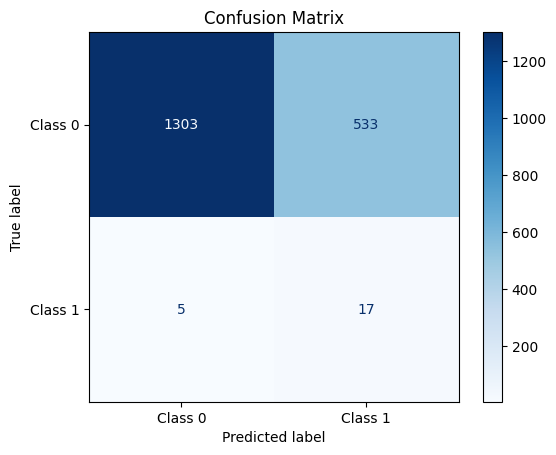

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Class 0', 'Class 1'], cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
oot_transformed['predicted'] = y_pred
oot_transformed['predicted_proba'] = y_test_proba
oot_transformed['state'] = oot_transformed[['V11_ES','V11_MG','V11_RJ','V11_SP']].idxmax(axis=1).str.replace('V11_', '')

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# Assuming y_true and y_scores are defined
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Create a Plotly figure
fig = go.Figure()

# Add the ROC curve
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    line=dict(color='#28DC7A', width=3),  # Set ROC curve color and width
    name=f'ROC Curve (AUC = {roc_auc:.2f})'
))

# Add the baseline
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(color='#003140', dash='dash', width=2),  # Set baseline color and dash style
    name='Baseline'
))

# Update layout
fig.update_layout(
    title=dict(
        text='Receiver Operating Characteristic (ROC) Curve',
        x=0.5,  # Center the title
        xanchor='center',
        font=dict(size=18)
    ),
    xaxis=dict(
        title='False Positive Rate',
        range=[0, 1],
        tickfont=dict(size=16, color='black'),  # Set axis tick color to black
        titlefont=dict(size=22, color='black'),  # Increase axis title font size and set to black
        linecolor='black',  # Make axis line black
        mirror=True,  # Mirror the axis lines
        linewidth=2,  # Set axis line width
    ),
    yaxis=dict(
        title='True Positive Rate',
        range=[0, 1.01],
        tickfont=dict(size=16, color='black'),  # Set axis tick color to black
        titlefont=dict(size=22, color='black'),  # Increase axis title font size and set to black
        linecolor='black',  # Make axis line black
        mirror=True,  # Mirror the axis lines
        linewidth=2,  # Set axis line width
    ),
    plot_bgcolor='white',  # Set background to white
    paper_bgcolor='white',  # Set paper background to white
    width=1000,  # Set figure width
    height=700,  # Set figure height
    legend=dict(
        x=0.75, y=0.25,
        bgcolor='rgba(255,255,255,0)',  # Transparent legend background
        bordercolor='black'
    )
)

# Show the plot
fig.show()


The results indicate significant variation in model performance across different states, with recall values ranging from 66.67% in MG to 100% in ES. While ES achieved a perfect recall, it also showed a high false positive rate (FPR) of 27.42%, indicating the model frequently misclassified negative cases as positive. RJ performed relatively well with an 83.33% recall and a moderate FPR of 27.83%, suggesting a more balanced trade-off between capturing positive cases and minimizing false positives. SP achieved a 75% recall with slightly better precision and a lower FPR compared to MG, which had the lowest recall (66.67%) and the highest FPR (34.76%). These results highlight the challenges of optimizing recall while controlling false positives, particularly in a highly imbalanced dataset, and suggest that the model may require state-specific adjustments to address these trade-offs effectively.

In [ ]:
state_metrics = pd.DataFrame()
for state in ['SP', 'ES', 'RJ', 'MG']:
  state_sample = oot_transformed[oot_transformed['state']==state]
  y_state = state_sample['TARGET']
  y_pred_state = state_sample['predicted_proba']
  metrics = compute_metrics(y_state, y_pred_state, optimal_threshold)
  metrics['state'] = state
  state_metrics = pd.concat([state_metrics, metrics])

state_metrics

,f1_score,accuracy,precision,fpr,fnr,recall,roc_auc,pr_auc,ks,brier,state
0,0.051724,0.725343,0.026786,0.274905,0.250000,0.750000,0.697509,0.027856,0.475095,0.141370,SP
0,0.046512,0.727575,0.023810,0.274247,0.000000,1.000000,0.991639,0.258333,0.725753,0.124577,ES
0,0.087719,0.723404,0.046296,0.278378,0.166667,0.833333,0.852703,0.157937,0.554955,0.136609,RJ
0,0.057143,0.652632,0.029851,0.347594,0.333333,0.666667,0.705437,0.224595,0.319073,0.160159,MG


# Interpretability

In [ ]:
# Create a DataFrame for interpretability
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

  Feature  Coefficient
4      V5     0.772109
2      V3     0.694702
1      V2     0.571136
5      V6     0.351556
9     V10     0.311961
8      V9     0.270024
0      V1     0.249042
3      V4     0.119385
7      V8    -0.282854
6      V7    -0.466574


This code uses SHAP to evaluate and explain the feature importance of the model. The results indicate that feature V5 has the highest importance, followed by V3 and V2, with scores of 0.489, 0.457, and 0.442, respectively. These features are driving most of the model’s predictions. On the other hand, features such as V9 and V4 have significantly lower importance, suggesting that they contribute less to the model’s decisions.

Feature importance
V5     0.489437
V3     0.456530
V2     0.441663
V6     0.287861
V8     0.274107
V7     0.216683
V10    0.192104
V1     0.171886
V4     0.067449
V9     0.053927
dtype: float64


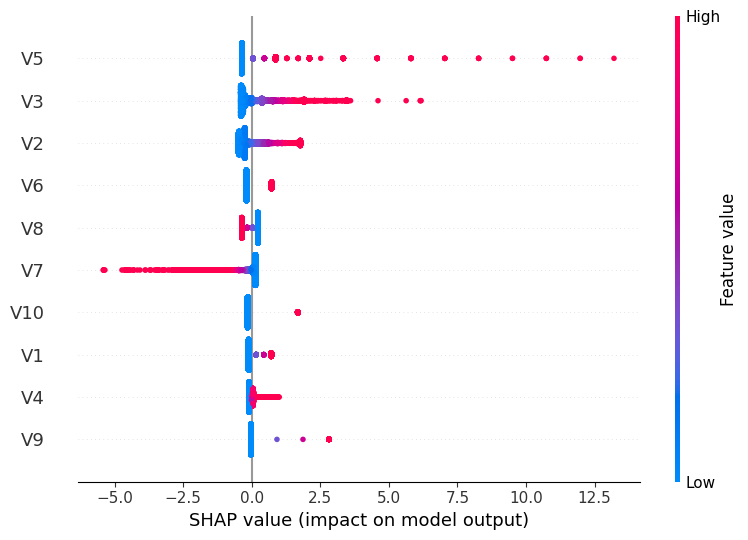

In [ ]:
explainer = shap.Explainer(model, X_train_transformed)
shap_values = explainer(X_train_transformed)

# Convert SHAP values to DataFrame
shap_values_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Calculate and print feature importance
feature_importance = shap_values_df.abs().mean().sort_values(ascending=False)
print('Feature importance',feature_importance, sep='\n')

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)  # Feature importance summary

In [ ]:
feature_importance= feature_importance.reset_index()
feature_importance.columns=['feature','value']

In [ ]:
feature_importance.reset_index()

# Create bar plot using Plotly
fig = px.bar(feature_importance, x='feature', y='value',
             title="Feature Importance")

# Show the plot
fig.show()

# Conclusion

This project aimed to develop a classification model to predict the target variable (target=1), which represents the positive cases in a highly imbalanced dataset. With a positive rate of just 1.07% and a total of 11,169 samples, the dataset posed significant challenges due to its class imbalance. It was assumed that it is critical not to miss any positive cases, so I focused primarily on optimizing the recall metric during model development.

After conducting several experiments with different strategies, including feature engineering, oversampling, and undersampling, the best performing model was the initial version using the raw dataset features, before any additional processing. The final model used Logistic Regression, which yielded the following results:

- F1 Score: 0.059441
- Accuracy: 0.710441
- Precision: 0.030909
- Recall: 0.772727
- ROC AUC: 0.773173
- PR AUC: 0.116604
- KS Statistic: 0.482422

While the model achieved a high recall rate, it also exhibited a relatively high false positive rate, which could have significant implications depending on the business context. In certain cases, the cost of false positives (predicting a positive case when it's actually negative) may outweigh the benefit of identifying all the positive cases, especially in fraud detection or similar applications. Therefore, it's crucial to evaluate the trade-off between false positives and false negatives based on the specific product requirements and the consequences of misclassifications.

**Next Steps**:
- Explore anomaly detection techniques to better identify outliers and rare events.
- Perform model tuning to fine-tune hyperparameters for better performance.
- Acquire additional data over a larger time frame and across more regions to enhance the model’s generalizability.
- Develop a custom model tailored specifically to each region, considering regional differences in the data.
- By addressing these next steps, the model’s accuracy and recall can likely be improved, enhancing its applicability for real-world deployment in fraud detection or similar applications.
- Verify the trade-off between false positive and false negative in the product.